# Demo on running the ground failure models and output figures manually

* To run this example, you must have the groundfailure codes and their dependencies installed and in your path (see [groundfailure readme] (https://github.com/usgs/groundfailure/) on how to do this)

## First, we'll manually run the models and plotting functions

### Import modules


In [1]:
#stdlib imports
from configobj import ConfigObj
import os
import matplotlib.pyplot as plt

#local imports
from gfail import (
    Nowicki2014Model,
    godt2008,
)
from gfail.utilities import parseConfigLayers, correct_config_filepaths
from gfail.webpage import create_kmz
#%matplotlib inline

### Set up file paths that will be used

In [2]:
# Directory containing model inputs
datadir = 'data/model_inputs/northridge'

# Path to config files
configfileG = '../defaultconfigfiles/models/godt_2008.ini'
configfileN = '../defaultconfigfiles/models/nowicki_2014_global.ini'

# Path to shakemap .xml files
shakefile = 'data/shakemaps/northridge.xml'
uncertfile = 'data/shakemaps/northridge_uncertainty.xml'

### Now we'll run the Godt et al. (2008) model

In [3]:
# read in the model config file and correct filepaths to absolute filepaths
configG = ConfigObj(configfileG)
configG = correct_config_filepaths(datadir, configG)

# run the model without saving the input layers
maplayers_godt = godt2008(shakefile, configG, saveinputs=False)

# read in mapping preferences from the config file specific to this model
plotorder, logscale, lims, colormaps, maskthreshes = parseConfigLayers(maplayers_godt, configG)

### Look at result quickly

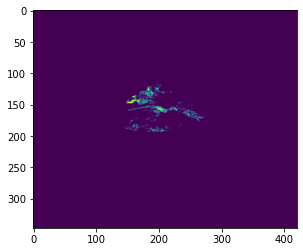

In [4]:
plt.imshow(maplayers_godt['model']['grid'].getData())

### Make kmz file

test.kmz


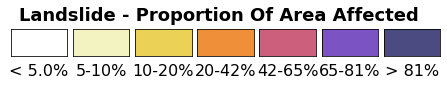

In [5]:
kmzfile = create_kmz(maplayers_godt['model'], 'test.kmz', levels=lims[0], mask=maskthreshes[0])
print(kmzfile)

## Now we'll run one of the logistic models and save the input layers so we can look at them

odict_keys(['pga', 'slope', 'friction', 'cti1', 'model'])


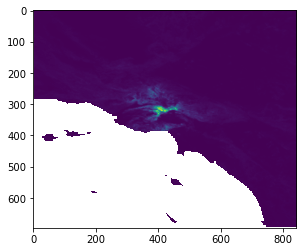

In [6]:
configN = ConfigObj(configfileN)
configN = correct_config_filepaths(datadir, configN)

# This time we'll save the inputs and plot those as well, saveinputs=True
# We'll also zoom in on the action
bounds = 'zoom'
zthresh = 0.1 # value used to determine the zoom bounds, this value is assumed to be the minimum value of interest

# This model is set up differently than the previous one, you first define the class, then calculate the model
# Set saveinputs to True in order to plot them later
lmn = Nowicki2014Model(shakefile, configN["nowicki_2014_global"], saveinputs=True)

maplayers_nowicki = lmn.calculate()

print(maplayers_nowicki.keys())

plt.imshow(maplayers_nowicki['model']['grid'].getData())

### Look at the input layers

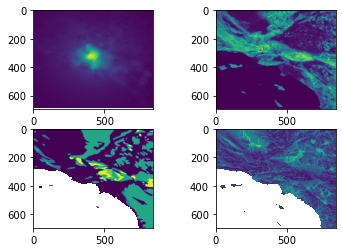

In [7]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(maplayers_nowicki['pga']['grid'].getData())
axes[0,1].imshow(maplayers_nowicki['slope']['grid'].getData())
axes[1,0].imshow(maplayers_nowicki['friction']['grid'].getData())
axes[1,1].imshow(maplayers_nowicki['cti1']['grid'].getData())